In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

In [52]:
%matplotlib inline

## Something is jacked up - the positions get shrunk to the middle

In [53]:
df = pd.read_csv('./BattingAverage.csv')
df['PriPosNumber'] = df['PriPosNumber'] - 1
df['PlayerNumber'] = df['PlayerNumber'] - 1
df.head()

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber
0,Fernando Abad,Pitcher,1,7,0,0
1,Bobby Abreu,Left Field,53,219,1,6
2,Tony Abreu,2nd Base,18,70,2,3
3,Dustin Ackley,2nd Base,137,607,3,3
4,Matt Adams,1st Base,21,86,4,2


In [54]:
position_averages = df.groupby(['PriPosNumber', 'PriPos']).sum().reset_index()
position_averages['avg'] = position_averages['Hits'] / position_averages['AtBats']
position_averages.drop(columns=['PlayerNumber'], inplace=True)

In [55]:
num_players = len(df)

grouped = df.groupby(['PriPosNumber', 'PlayerNumber']).agg({'Hits': [np.sum, np.size]}).reset_index()
grouped.columns = ['PriPosNumber', 'PlayerNumber', 'Hits', 'total']
num_positions = len(np.unique(df['PriPosNumber']))
print('num_positions ', num_positions)

# position id series needs to be the length of the positions
position_id = grouped['PriPosNumber']
player_id = df['PlayerNumber']

num_positions  9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_player, concentration_position, μ_position]
Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [01:27<00:00, 295.57draws/s]


                mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
μ_position[0]  0.237  0.004   0.229    0.245        0.0      0.0   18507.0   
μ_position[1]  0.228  0.009   0.211    0.245        0.0      0.0   19659.0   
μ_position[2]  0.239  0.010   0.220    0.258        0.0      0.0   22787.0   
μ_position[3]  0.221  0.012   0.200    0.244        0.0      0.0   19504.0   
μ_position[4]  0.234  0.012   0.213    0.256        0.0      0.0   18372.0   
...              ...    ...     ...      ...        ...      ...       ...   
θ_player[943]  0.222  0.076   0.089    0.368        0.0      0.0   38800.0   
θ_player[944]  0.279  0.018   0.245    0.314        0.0      0.0   49071.0   
θ_player[945]  0.201  0.044   0.117    0.283        0.0      0.0   44396.0   
θ_player[946]  0.122  0.037   0.053    0.191        0.0      0.0   40542.0   
θ_player[947]  0.267  0.018   0.232    0.301        0.0      0.0   45416.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
μ_position[

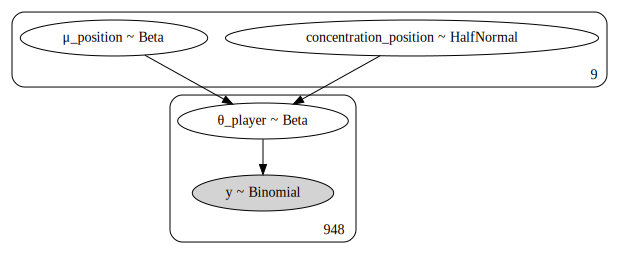

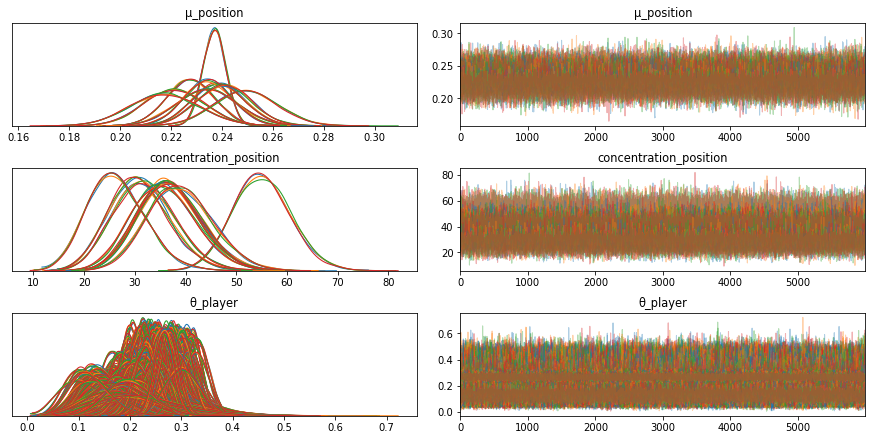

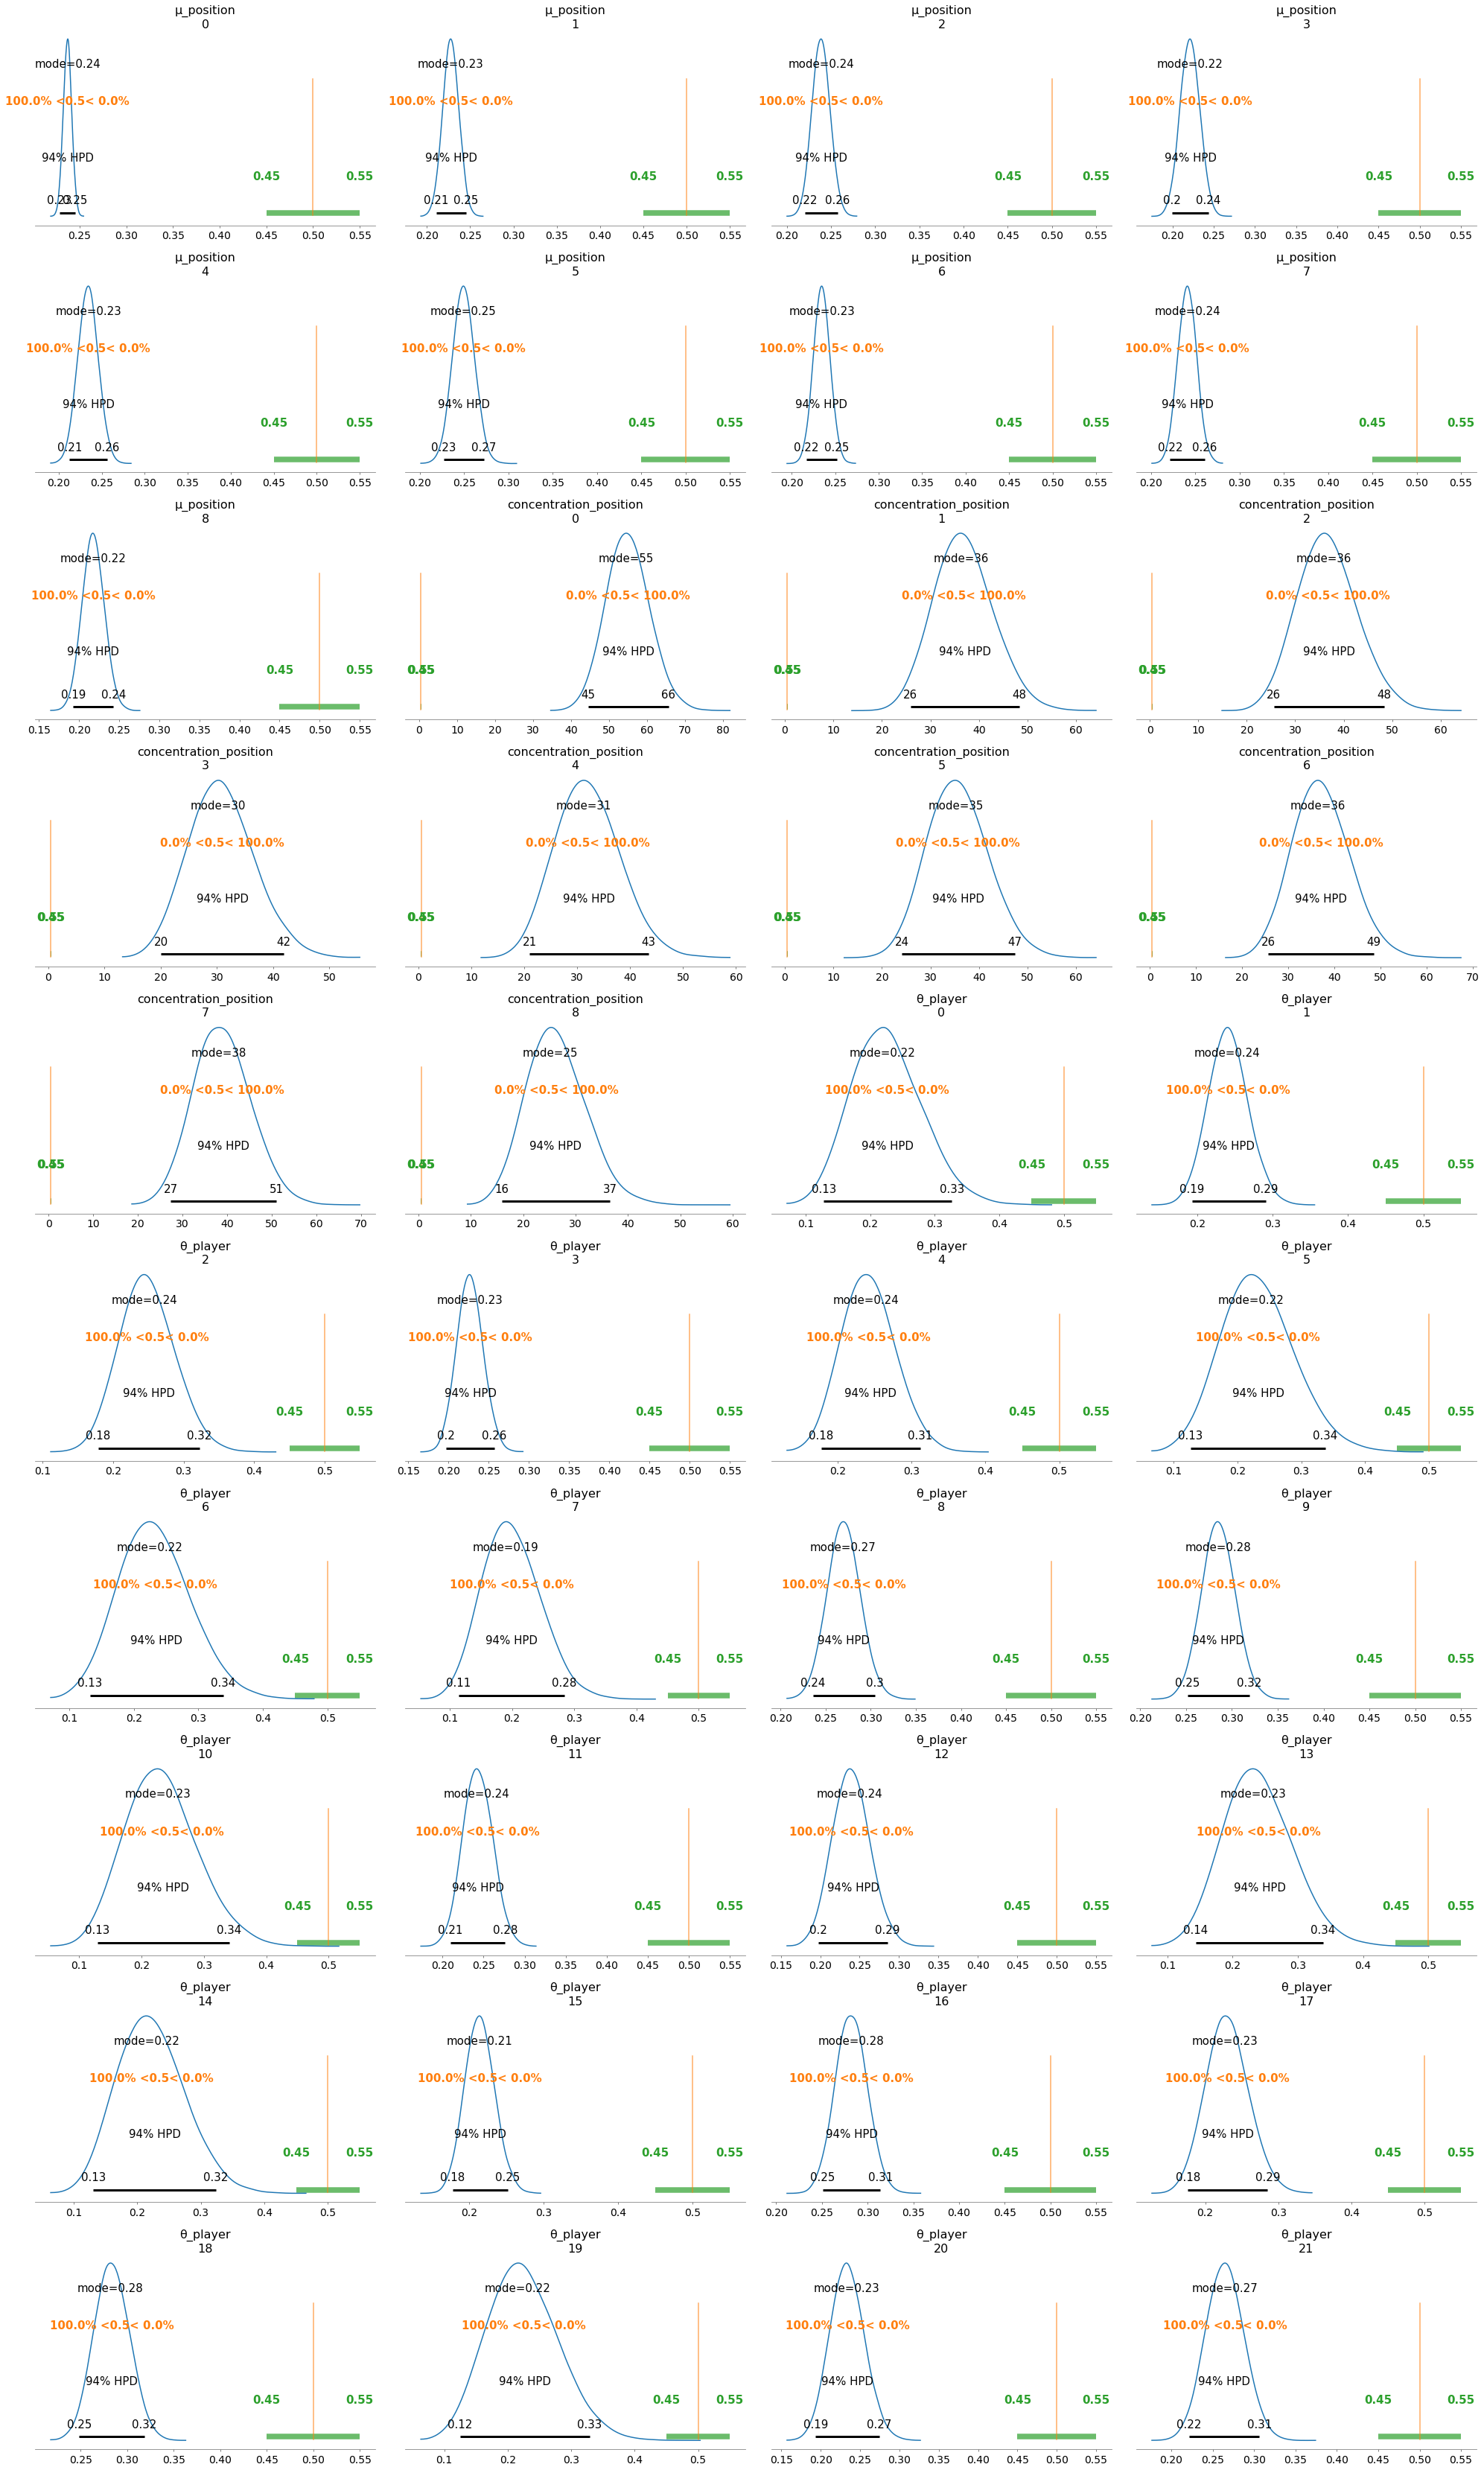

In [56]:
with pm.Model() as model_h_short:
    μ_position = pm.Beta('μ_position', 1, 1, shape=num_positions)
    concentration_position = pm.HalfNormal('concentration_position', 10, shape=num_positions)

    θ_player = pm.Beta('θ_player',
                       alpha=μ_position[position_id]*concentration_position[position_id],
                       beta=(1.0-μ_position[position_id])*concentration_position[position_id],
                       shape=num_players)
    y = pm.Binomial('y', n=df['AtBats'], p=θ_player[player_id], observed=df['Hits'])

    trace = pm.sample(6000)
    print(az.summary(trace))
    pm.traceplot(trace)
    az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_short)

In [ ]:
with pm.Model() as model_h:
    center_all = pm.Beta('center_all', 1, 1)
    concentration_all = pm.HalfNormal('concentration_all', 10)

    center_position = pm.Beta('center_position',
                              alpha=center_all*concentration_all,
                              beta=(1-center_all)*concentration_all,
                              shape=num_positions)

    concentration_position = pm.HalfNormal('concentration_position',
                                           10,
                                           shape=num_positions)

    center_player = pm.Beta('center_player',
                       alpha=center_position[position_id]*concentration_position[position_id],
                       beta=(1.0-center_position[position_id])*concentration_position[position_id],
                       shape=num_players)

    y = pm.Binomial('y', n=df['AtBats'], p=center_player[player_id], observed=df['Hits'])

    trace = pm.sample(4000, random_seed=123)
    print(az.summary(trace))
    pm.traceplot(trace)
    az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h)


[[0.24220228 0.22293111 0.25080487 ... 0.24427727 0.24462152 0.2175342 ]
 [0.25017904 0.23376557 0.24701381 ... 0.23289341 0.22283746 0.2286457 ]
 [0.24407115 0.22869032 0.25613559 ... 0.23007512 0.2174447  0.2187067 ]
 ...
 [0.23511238 0.2268638  0.23790373 ... 0.24045996 0.2383085  0.23189822]
 [0.23929117 0.22914463 0.23969351 ... 0.22918478 0.24559422 0.2372083 ]
 [0.23679355 0.24384212 0.24453876 ... 0.2350993  0.24596476 0.21563357]]
